In [28]:
import pandas as pd
import math


In [29]:
colors = {
    "People\'s Action Party": '#0000FF',  # Blue
    "Workers' Party": '#FF0000',  # Red
    "National Solidarity Party": '#00FF00',  # Green
    "Singapore Democratic Party": '#FFFF00',  # Yellow
    "Reform Party": '#FFA500',  # Orange
    "Singapore People's Party": '#800080',  # Purple
    "Progress Singapore Party": '#00FFFF',  # Cyan
    "People's Power Party": '#FF00FF',  # Magenta
    "Red Dot United": '#A52A2A',  # Brown
    "Singapore Democratic Alliance": '#808080',  # Gray
    "Singaporeans First": '#8B4513',  # SaddleBrown
    "Peoples Voice": '#FFD700',  # Gold
    "United People's Front": '#000000', # Black
    "Singapore Justice Party": '#FFC0CB',  # Pink
    "Independent": '#3b3b3b'  # Gray

}

In [30]:
GE_years = [1988,1991,1997,2001,2006,2011,2015,2020]

all_seat_changes=pd.DataFrame(columns = ['Party','Seat Change','Year'])


for year in GE_years:

    ## Set up dataframe
    file_path = 'Actual_results/'+ str(year)+'-Table 1.csv'
    df = pd.read_csv(file_path)

    # Remove empty rows and columns
    df = df.dropna(how='all').dropna(axis=1, how='all')

    df.columns = df.iloc[0]
    df = df[1:]

    # Reset the index
    df.reset_index(drop=True, inplace=True)


    ## Data Cleaning 

    # Fill up rows, which dont have Constituency and Seats, with the respective constituency and seats
    for i in range(1, len(df)):
        if pd.isna(df.at[i, df.columns[0]]):

            df.iloc[i][0] = df.iloc[i-1][0]
            df.iloc[i][1] = df.iloc[i-1][1]

    # Remove SMCs
    df = df[df['Seats'] != '1']

    # Remove walkovers (if no vote percentage)
    df = df.dropna(subset='%')

    df['%']=df['%'].str[:5]
    df['%']=df['%'].astype(float)
    df['Seats']=df['Seats'].astype(int)


    # Remove bug substring
    df['Party']=df['Party'].str.replace('\xa0','',regex=False)

    df.reset_index(drop=True, inplace=True)

    ## Calculations

    # Calculate Old Seats
    df['Old Seats']=0
    for i in range(0, len(df)):
        total_seats = df.iloc[i]['Seats']
        vote_percentage=df.iloc[i]['%']
        if df.iloc[i]['%']> 50:
            df.at[i,'Old Seats'] = total_seats
        else:
            df.at[i,'Old Seats'] = 0

    # Calculate new seats (scenario changes here)
    df['New Seats']=0
    for i in range(0, len(df)):
        total_seats = df.iloc[i]['Seats']
        vote_percentage = df.iloc[i]['%']
        if df.iloc[i]['Party'] == "People's Action Party":
            new_seats = math.ceil(total_seats*vote_percentage/100)      # Change here
            df.at[i,'New Seats'] = new_seats

        else:
            new_seats = math.floor(total_seats*vote_percentage/100)     # Change here
            df.at[i,'New Seats'] = new_seats

    ## Calculate Seat Changes 
    df['Seat Change']=0
    for i in range(0, len(df)):
        df.at[i,'Seat Change'] = df.iloc[i]['New Seats']-df.iloc[i]['Old Seats']

    df.to_csv('ProPAP_results/'+str(year)+'_results.csv',index=False)
    
    ## Collate Seat Changes
    seat_changes = df.groupby('Party')['Seat Change'].sum().reset_index()
    seat_changes['Year']=year
    seat_changes

    all_seat_changes=pd.concat([all_seat_changes,seat_changes],ignore_index=True)

In [31]:
all_seat_changes.to_csv('ProPAP_results/all_results.csv',index=False)

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
data = all_seat_changes

# Group all parties except People's Action Party and Workers' Party under "Others"
data['Party Grouped'] = data['Party'].apply(lambda x: x if x in ["People's Action Party", "Workers' Party", "Singapore Democratic Party", "Singapore People's Party"] else 'Others')

# Summarize the seat changes by the new grouping
grouped_summary = data.groupby(['Year', 'Party Grouped'])['Seat Change'].sum().reset_index()


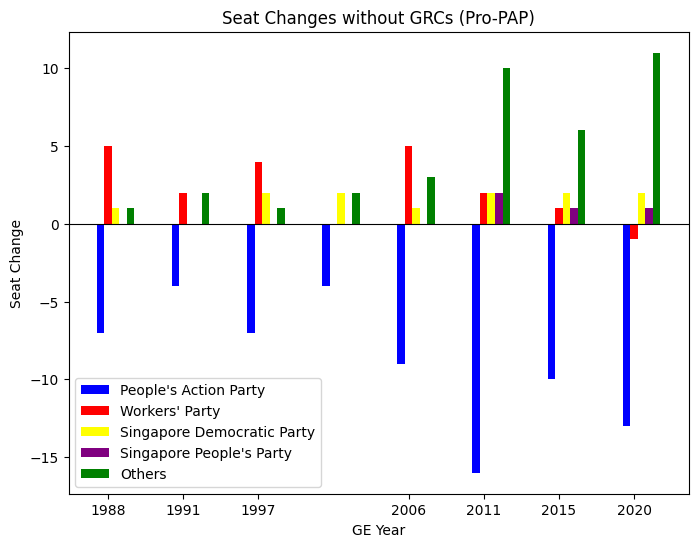

In [34]:
# Adjust the grouped bar chart to ensure matching data lengths
plt.figure(figsize=(8, 6))

# Define the width of each bar
bar_width = 0.10

# Filter data for each group
pap_data = grouped_summary[grouped_summary['Party Grouped'] == "People's Action Party"]
wp_data = grouped_summary[grouped_summary['Party Grouped'] == "Workers' Party"]
sdp_data = grouped_summary[grouped_summary['Party Grouped'] == "Singapore Democratic Party"]
spp_data = grouped_summary[grouped_summary['Party Grouped'] == "Singapore People's Party"]
others_data = grouped_summary[grouped_summary['Party Grouped'] == 'Others']

# Generate positions for the bars
years = sorted(grouped_summary['Year'].unique())
positions = {year: index for index, year in enumerate(years)}

# Adjust positions for each group
pap_positions = [positions[year] - 2*bar_width for year in pap_data['Year']]
wp_positions = [positions[year] - bar_width for year in wp_data['Year']]
sdp_positions = [positions[year] for year in sdp_data['Year']]
spp_positions = [positions[year] + bar_width for year in spp_data['Year']]
others_positions = [positions[year] + 2*bar_width for year in others_data['Year']]

# Plotting bars for each party group with specified colors
plt.bar(pap_positions, pap_data['Seat Change'], color=colors["People\'s Action Party"], width=bar_width, label="People's Action Party")
plt.bar(wp_positions, wp_data['Seat Change'], color=colors["Workers' Party"], width=bar_width, label="Workers' Party")
plt.bar(sdp_positions, sdp_data['Seat Change'], color=colors["Singapore Democratic Party"], width=bar_width, label= "Singapore Democratic Party")
plt.bar(spp_positions, spp_data['Seat Change'], color=colors["Singapore People's Party"], width=bar_width, label= "Singapore People's Party")
plt.bar(others_positions, others_data['Seat Change'], color='green', width=bar_width, label='Others')

# Set the x-axis to show only the election years
plt.title('Seat Changes without GRCs (Pro-PAP)')
plt.xlabel('GE Year')
plt.ylabel('Seat Change')
plt.xticks(wp_positions, wp_data['Year'])  # Set positions for x-axis labels
plt.legend()
plt.grid(False)
plt.axhline(y=0, color='black', linewidth=0.8)  # Add the y=0 horizontal line
plt.show()


In [37]:
## Look at specific year's results

year = 2020

df = pd.read_csv('ProPAP_results/'+str(year)+'_results.csv')
                 
df

,Division,Seats,Voters,Rejected,Party,Candidate(s),Votes,%,Sample counts %,Swing,Margins,Old Seats,New Seats,Seat Change
0,Bishan–Toa Payoh GRC[204],4,"101,220","2,049",People's Action Party,Ng Eng Hen\nChee Hong Tat\nChong Kee Hiong\nSa...,"62,983",67.23,67 / 100,6.36,34.46%,4,3,-1
1,Bishan–Toa Payoh GRC[204],4,NaN,NaN,Singapore People's Party,Steve Chia\nWilliamson Lee\nMelvyn Chiu\nOsman...,"30,696",32.77,33 / 100,6.36,NaN,0,1,1
2,Chua Chu Kang GRC[205],4,"106,632","1,410",People's Action Party,Gan Kim Yong\nLow Yen Ling\nDon Wee\nZhulkarna...,"59,554",58.64,59 / 100,18.25,17.28%,4,3,-1
3,Chua Chu Kang GRC[205],4,NaN,NaN,Progress Singapore Party,Francis Yuen\nAbdul Rahman Mohamad\nTan Meng W...,"42,012",41.36,41 / 100,NaN,NaN,0,1,1
4,Holland–Bukit Timah GRC[206],4,"114,973","1,999",People's Action Party,Vivian Balakrishnan\nSim Ann\nChristopher de S...,"71,218",66.36,68 / 100,0.24,32.72%,4,3,-1
5,Holland–Bukit Timah GRC[206],4,NaN,NaN,Singapore Democratic Party,Tan Jee Say\nJames Gomez\nMin Cheong\nAlfred Tan,"36,100",33.64,32 / 100,0.24,NaN,0,1,1
6,Jalan Besar GRC[207],4,"107,720","2,948",People's Action Party,Josephine Teo\nHeng Chee How\nDenise Phua\nWan...,"64,631",65.36,67 / 100,2.37,30.72%,4,3,-1
7,Jalan Besar GRC[207],4,NaN,NaN,Peoples Voice,Lim Tean\nMichael Fang Amin\nLeong Sze Hian\nN...,"34,261",34.64,33 / 100,NaN,NaN,0,1,1
8,Marsiling–Yew Tee GRC[208],4,"117,077","2,097",People's Action Party,Lawrence Wong\nAlex Yam\nZaqy Mohamad\nHany Soh,"69,813",63.18,64 / 100,5.55,26.36%,4,3,-1
9,Marsiling–Yew Tee GRC[208],4,NaN,NaN,Singapore Democratic Party,Benjamin Pwee\nBryan Lim\nDamanhuri Abas\nKhun...,"40,690",36.82,36 / 100,5.55,NaN,0,1,1


In [36]:
# Look at specific year's seat change for all parties

df = all_seat_changes
year = 2020

df = df[df['Year'] == year]

df

,Party,Seat Change,Year,Party Grouped
37,National Solidarity Party,2,2020,Others
38,People's Action Party,-13,2020,People's Action Party
39,Peoples Voice,1,2020,Others
40,Progress Singapore Party,5,2020,Others
41,Red Dot United,1,2020,Others
42,Reform Party,1,2020,Others
43,Singapore Democratic Alliance,1,2020,Others
44,Singapore Democratic Party,2,2020,Singapore Democratic Party
45,Singapore People's Party,1,2020,Singapore People's Party
46,Workers' Party,-1,2020,Workers' Party
